In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import statsmodels.api as sm

from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller

from glassnode import *
from BandPass import BandPass
from smoothers import strided_app,VWAP
from SVR_FN import SVR_predictor,forecast_ols_evaluation,regression_cm

sns.set()
plt.rcParams['figure.figsize'] = [15, 7]

In [2]:
def hpwrap(x,pars):
    _,trend = sm.tsa.filters.hpfilter(x,pars)
    return trend

In [3]:
def predcition_analysis(Xdf,period,n_train):    
    freq = np.unique(Xdf.index.strftime(period))
    StridedMonths = strided_app(freq,n_train,1)

    frequency = period
    Target = ['Target']

    Features = Xdf.columns

    kernel = 'linear'

    Y = []
    Prc = []

    for i in tqdm(range(StridedMonths.shape[0])):

        trainPeriod = list(StridedMonths[i][:-1])
        cvPeriod = StridedMonths[i][-1]
  
        train_price = price.shift(-1).loc[price.index.strftime(period).isin(trainPeriod)]
        cv_price = price.shift(-1).loc[price.index.strftime(period).isin([cvPeriod])]
        pr = pd.concat([train_price,cv_price],axis = 0).sort_index()
        
        denoised_price_train = hpwrap(np.log(train_price),10)
        denoised_price_all = hpwrap(np.log(pr),10)


        logPx = denoised_price_train
        logPx.loc[denoised_price_all.index[-1]] = denoised_price_all.iloc[-1]
        
        r = 100*logPx.diff()
        df = pd.concat([r.rename('Target'),Xdf.loc[r.index]],axis = 1).dropna()
    
        self = SVR_predictor(df,trainPeriod,cvPeriod,frequency,Target,Features,kernel)
        self.train_cv_split() 
        self.fit()
        Y_ = self.predict()
        Y.append(Y_)
        Prc.append({'month':cvPeriod,'prc':regression_cm(Y_)})

    Y = pd.concat(Y,axis = 0)
    return Y

In [4]:
Addresses = ['count', 'sending_count','receiving_count', 
             'active_count','non_zero_count', 'min_1_count',
             'min_10_count', 'min_100_count','min_1k_count', 
             'min_10k_count']

Blockchain = ['utxo_created_count', 'utxo_created_value_sum',
              'utxo_spent_value_sum', 'utxo_created_value_mean',
              'utxo_created_value_median','utxo_spent_value_median', 
              'utxo_profit_count','utxo_loss_count', 
              'utxo_profit_relative','block_height', 
              'block_count','block_interval_median']

Distribution = ['exchange_net_position_change','balance_1pct_holders', 
                'gini']

Indicators = ['rhodl_ratio', 'balanced_price_usd','difficulty_ribbon_compression',
               'nvt','nvts', 'cdd_supply_adjusted_binary','average_dormancy_supply_adjusted',
               'reserve_risk', 'cyd','cdd90_age_adjusted', 'sopr', 'asol','msol', 'unrealized_profit',
               'unrealized_loss', 'nupl_less_155','nupl_more_155', 'dormancy_flow',
               'net_realized_profit_loss','realized_profit_loss_ratio','stock_to_flow_deflection', 'realized_loss',
               'sol_1h', 'sol_1h_24h', 'sol_1d_1w','sol_1w_1m', 'sol_1m_3m', 'sol_3m_6m','sol_6m_12m', 
               'sol_1y_2y', 'sol_2y_3y','sol_7y_10y']

Market = ['price_drawdown_relative','deltacap_usd', 'marketcap_usd', 'mvrv','mvrv_z_score']

Mining = ['difficulty_latest','revenue_from_fees', 'marketcap_thermocap_ratio']

Supply = ['current', 'issued', 'inflation_rate','active_24h', 'active_1d_1w', 
          'active_1w_1m','active_1m_3m', 'active_3m_6m', 'active_6m_12m',
          'active_1y_2y', 'active_2y_3y','active_more_1y_percent',
           'active_more_3y_percent']

Transactions = ['size_mean', 'size_sum','transfers_volume_adjusted_sum',
                'transfers_volume_adjusted_median',
                'transfers_volume_from_exchanges_mean',
                'transfers_volume_exchanges_net',
                'transfers_to_exchanges_count',
                'transfers_from_exchanges_count']

urls = []

for a in Addresses:
    urls += [URLS['Addresses']+a]

for b in Blockchain:
    urls += [URLS['Blockchain']+b]

for d in Distribution:
    urls += [URLS['Blockchain']+d]

for i in Indicators:
    urls += [URLS['Indicators']+i]

for m in Mining:
    urls += [URLS['Mining']+m]

for s in Supply:
    urls += [URLS['Supply']+s]

for t in Transactions:
    urls += [URLS['Transactions']+t]

for m1 in Market:
    urls += [URLS['Market']+m1]

In [5]:

GLASSNODE_API_KEY = '1vUcyF35hTk9awbNGszF0KcLuYH'

self = GlassnodeClient()
self.set_api_key(GLASSNODE_API_KEY)

url = URLS['Market'] + 'price_usd_ohlc'
a ='BTC'
c = 'native'
i='24h'

ohlc = self.get(url,a,i,c)
price = ohlc['c']

In [6]:

GLASSNODE_API_KEY = '1vUcyF35hTk9awbNGszF0KcLuYH'

self = GlassnodeClient()
self.set_api_key(GLASSNODE_API_KEY)

features = []

for u in tqdm(urls):
    a,c,i='BTC','native','24h'
    z = self.get(u,a,i,c)
    
    try:
        features.append(z.rename(u.split('/')[-1]))
    except:
        message = f"cannot get {u.split('/')[-1]}."
        print(message)

features = pd.concat(features,axis = 1)
features = features.loc['2013':]

 27%|███████████▍                               | 23/86 [00:15<00:35,  1.77it/s]

404 Client Error: Not Found for url: https://api.glassnode.com/v1/metrics/blockchain/exchange_net_position_change?a=BTC&i=24h&c=native&api_key=1vUcyF35hTk9awbNGszF0KcLuYH
404 page not found

Extra data: line 1 column 5 (char 4)
cannot get exchange_net_position_change.


 28%|████████████                               | 24/86 [00:15<00:30,  2.03it/s]

404 Client Error: Not Found for url: https://api.glassnode.com/v1/metrics/blockchain/balance_1pct_holders?a=BTC&i=24h&c=native&api_key=1vUcyF35hTk9awbNGszF0KcLuYH
404 page not found

Extra data: line 1 column 5 (char 4)
cannot get balance_1pct_holders.


 29%|████████████▌                              | 25/86 [00:16<00:26,  2.29it/s]

404 Client Error: Not Found for url: https://api.glassnode.com/v1/metrics/blockchain/gini?a=BTC&i=24h&c=native&api_key=1vUcyF35hTk9awbNGszF0KcLuYH
404 page not found

Extra data: line 1 column 5 (char 4)
cannot get gini.


100%|███████████████████████████████████████████| 86/86 [01:00<00:00,  1.43it/s]


In [7]:

processed_features = []

for c in tqdm(features.columns):
    series = features[c]
    ser = features[c].astype('float32').copy()
    
    Nd = str(ser.abs().mean()).split('.')[0]
    Ndigits = len(list(Nd))
    
    if Ndigits >1:
        divisor = eval(str('1e')+str(Ndigits))/10
        ser = ser/divisor
    
    adf = adfuller(ser, maxlag=5, regression='ct')
    
    if adf[1] >= 0.1:
        if ser.min() > 0:
            processed_features.append(100*np.log(ser).diff().rename(c))
        else:
            processed_features.append(100*ser.diff().rename(c))
    else:
        processed_features.append(ser.rename(c))
  
processed_features = pd.concat(processed_features,axis = 1)

100%|██████████████████████████████████████████| 83/83 [00:00<00:00, 246.87it/s]


In [8]:


xcols = ['sopr','mvrv_z_score',
         'marketcap_thermocap_ratio',
         'nvts',
         'realized_profit_loss_ratio',
         'rhodl_ratio','stock_to_flow_deflection','inflation_rate']

Xdf = processed_features[xcols]

In [9]:
Y = predcition_analysis(Xdf,'%Y-%m-%d',120)

100%|███████████████████████████████████████| 3124/3124 [01:36<00:00, 32.23it/s]


In [10]:
out = forecast_ols_evaluation(Y['Target'],Y['estimated'])
X = sm.add_constant(Y['estimated'])
y = Y['Target']
mod = sm.OLS(y,X).fit()

mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     206.3
Date:                Thu, 18 Nov 2021   Prob (F-statistic):           2.36e-45
Time:                        11:38:54   Log-Likelihood:                -7555.8
No. Observations:                3124   AIC:                         1.512e+04
Df Residuals:                    3122   BIC:                         1.513e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0929      0.049      1.890      0.059      -0.003       0.189
estimated      0.5524      0.038     14.364      0.000       0.477       0.628
==============================================================================
Omnibus:                      676.989   Durbin-Watson:                   1.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9139.868
Skew:                          -0.640   Prob(JB):                         0.00
Kurtosis:                      11.281   Cond. No.                         1.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='t'>

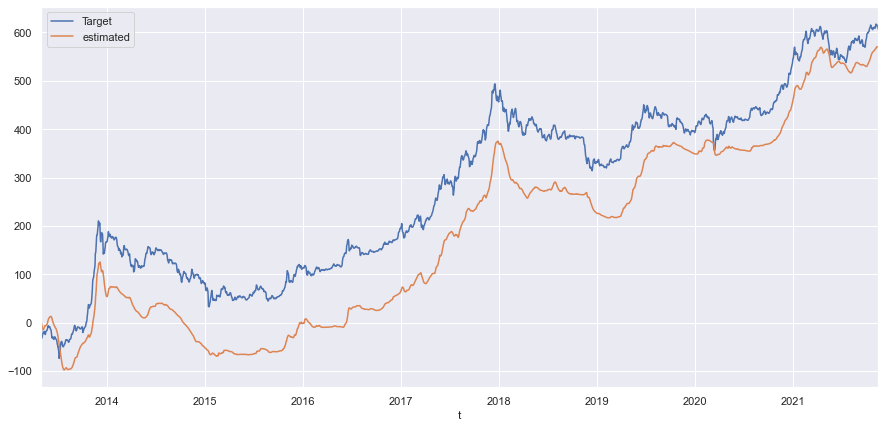

In [11]:
Y.cumsum().plot(figsize = (15,7))

In [12]:
print('pseudo precision:',f'{100*regression_cm(Y)}%')

pseudo precision: 58.7708066581306%


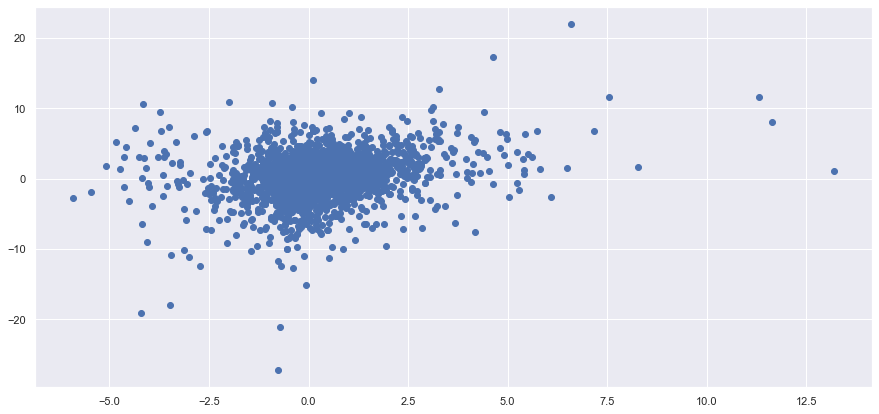

In [13]:
plt.scatter(Y.estimated,Y.Target)

<AxesSubplot:xlabel='t'>

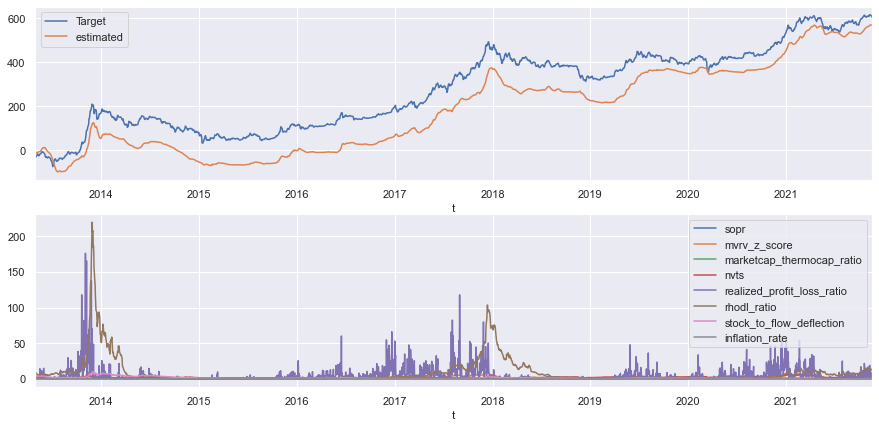

In [14]:
f,a = plt.subplots(nrows = 2)
Y.cumsum().plot(ax= a[0],figsize = (15,7))
Xdf.loc[Y.cumsum().index].plot(ax = a[1])